In [1]:
import pandas as pd
import os
from textblob import TextBlob
import numpy as np
from scipy.stats import zscore
from datetime import datetime, timedelta

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
foo = './'
os.listdir(foo)

['.ipynb_checkpoints',
 'all-the-news-2-1.csv',
 'assignment_draft0.ipynb',
 'average_sentiment.csv',
 'conf_matrix_orig.png',
 'Forecasting the Stock Market using News Sentiment Analysis .cgi.pdf',
 'joined.csv',
 'mean_polarity.csv',
 'news-titles-2-1.csv',
 'news-titles-finance-2-1.csv',
 'YahooFinancials package.xls']

# Уменьшение объема обрабатываемых текстовых данных
Выбор только заголовков, а не текстов целиком.

In [5]:
%%time
df = pd.read_csv(foo + 'all-the-news-2-1.csv', usecols = ['date', 'year', 'month', 'day', 'title', 'section', 'publication'])

CPU times: total: 1min 58s
Wall time: 2min 3s


In [6]:
df.shape, df.columns

((2688878, 7),
 Index(['date', 'year', 'month', 'day', 'title', 'section', 'publication'], dtype='object'))

In [7]:
df.to_csv(foo+'news-titles-2-1.csv')

Удаление строк где категория не содержит бизнес или финансы

In [8]:
df.section.value_counts()[:50]

Market News                  108724
World News                   108651
Business News                 96395
Wires                         67352
Financials                    57845
politics                      53496
us                            51242
Intel                         39805
Bonds News                    39672
Politics                      33875
Healthcare                    30883
world                         28530
opinion                       27465
Consumer Goods and Retail     26766
Sports News                   26324
business                      25335
tv                            24783
sports                        23909
Tech                          21605
arts                          21230
movies                        19683
Commodities                   17620
Deals                         15847
style                         15355
Tech by VICE                  15222
Entertainment                 13773
health                        13629
nyregion                    

In [9]:
strings = ['busines', 'financ']
def onbusiness(s):
    s = str(s).lower()
    for l in strings:
        if l in s:
            return True
    return False
df['onbus'] = df.section.apply(onbusiness)


In [10]:
sum(df['onbus'])

190304

In [11]:
df[df.onbus]

,date,year,month,day,title,section,publication,onbus
5,2019-06-17 00:00:00,2019,6.0,17,"ECB's Coeure: If we decide to cut rates, we'd ...",Financials,Reuters,True
11,2019-06-23 00:00:00,2019,6.0,23,Hudson's Bay's chairman's buyout bid pits reta...,Business News,Reuters,True
22,2018-12-28 00:00:00,2018,12.0,28,Wells Fargo to pay $575 million in settlement ...,Business News,Reuters,True
24,2019-05-21 00:00:00,2019,5.0,21,Factbox: Investments by automakers in the U.S....,Business News,Reuters,True
27,2019-02-05 00:00:00,2019,2.0,5,Exclusive: Britain's financial heartland unbow...,Business News,Reuters,True
...,...,...,...,...,...,...,...,...
2688234,2020-03-13 00:00:00,2020,3.0,13,AMC and Regal to start capping movie theater a...,Business,The Verge,True
2688251,2020-03-13 00:00:00,2020,3.0,13,"Etsy is trying to get bigger, and it’s pushing...",Business,The Verge,True
2688471,2020-03-20 00:00:00,2020,3.0,20,"Walmart wants to hire 150,000 workers to meet ...",Business,The Verge,True
2688489,2020-03-20 00:00:00,2020,3.0,20,Peloton temporarily suspends sales and deliver...,Business,The Verge,True


In [12]:
df[df.onbus].drop(['onbus'], axis=1).to_csv(foo+'news-titles-finance-2-1.csv')

# Тональность 
(она же sentiment)

In [13]:
df = pd.read_csv(foo+'news-titles-finance-2-1.csv', index_col=0)
df

,date,year,month,day,title,section,publication
5,2019-06-17 00:00:00,2019,6.0,17,"ECB's Coeure: If we decide to cut rates, we'd ...",Financials,Reuters
11,2019-06-23 00:00:00,2019,6.0,23,Hudson's Bay's chairman's buyout bid pits reta...,Business News,Reuters
22,2018-12-28 00:00:00,2018,12.0,28,Wells Fargo to pay $575 million in settlement ...,Business News,Reuters
24,2019-05-21 00:00:00,2019,5.0,21,Factbox: Investments by automakers in the U.S....,Business News,Reuters
27,2019-02-05 00:00:00,2019,2.0,5,Exclusive: Britain's financial heartland unbow...,Business News,Reuters
...,...,...,...,...,...,...,...
2688234,2020-03-13 00:00:00,2020,3.0,13,AMC and Regal to start capping movie theater a...,Business,The Verge
2688251,2020-03-13 00:00:00,2020,3.0,13,"Etsy is trying to get bigger, and it’s pushing...",Business,The Verge
2688471,2020-03-20 00:00:00,2020,3.0,20,"Walmart wants to hire 150,000 workers to meet ...",Business,The Verge
2688489,2020-03-20 00:00:00,2020,3.0,20,Peloton temporarily suspends sales and deliver...,Business,The Verge


Проверяем, как выглядят даты:

In [14]:
df.date.value_counts()

2020-03-17 00:00:00    413
2020-03-19 00:00:00    412
2020-03-20 00:00:00    408
2020-03-11 00:00:00    363
2020-03-16 00:00:00    349
                      ... 
2017-02-04 03:00:24      1
2017-02-25 12:00:10      1
2017-02-07 20:19:47      1
2017-02-20 19:03:49      1
2020-04-01 05:00:33      1
Name: date, Length: 20080, dtype: int64

"Обрезаем" из дат информацию о времени:

In [15]:
df['date1'] = df.date.apply(lambda x: x.split(' ')[0])
df.date1.value_counts()

2020-03-17    430
2020-03-19    429
2020-03-20    425
2020-03-11    377
2020-03-16    368
             ... 
2019-04-21     11
2016-12-31     10
2020-03-29      9
2019-08-10      8
2020-04-01      5
Name: date1, Length: 1553, dtype: int64

Проверяем, что делает TextBlob:

In [17]:
for i in range(50,70):
    s = df.iloc[i].title
    print(s, ' | ', TextBlob(s).sentiment)

Trump says U.S. farmers to get $15 billion in aid amid China trade war  |  Sentiment(polarity=0.0, subjectivity=0.0)
China confident it can reach 2018 growth target:  cabinet research head  |  Sentiment(polarity=0.5, subjectivity=0.8333333333333334)
Oil prices fall 1% as economic worries outweigh tanker tensions  |  Sentiment(polarity=0.2, subjectivity=0.2)
Trump to make China tariffs decision 'right after G20'  |  Sentiment(polarity=0.2857142857142857, subjectivity=0.5357142857142857)
China says tariffs on U.S. goods to be used to ease impact of trade fight  |  Sentiment(polarity=0.0, subjectivity=0.0)
Factbox: Tariff wars - duties imposed by Trump and U.S. trading partners  |  Sentiment(polarity=0.0, subjectivity=0.0)
China says U.S. demand on its state-owned enterprises is 'invasion' on economic sovereignty  |  Sentiment(polarity=0.2, subjectivity=0.2)
Clash over Trump tariffs heats up with barrage of WTO litigation  |  Sentiment(polarity=0.0, subjectivity=0.0)
Nissan plans April sh

Проверяем, есть ли строки с пустыми заголовками

In [18]:
df.shape, df.dropna(subset = 'title').shape

((190304, 8), (190304, 8))

Вычисляем тональность для каждого заголовка и записываем в новые столбцы 'polarity', 'subjectivity'

In [19]:
%%time
sent = df.title.apply(lambda s: TextBlob(s).sentiment)
df['polarity'] = [s[0] for s in sent]
df['subjectivity'] = [s[1] for s in sent]
df

CPU times: total: 1min 24s
Wall time: 1min 25s


,date,year,month,day,title,section,publication,date1,polarity,subjectivity
5,2019-06-17 00:00:00,2019,6.0,17,"ECB's Coeure: If we decide to cut rates, we'd ...",Financials,Reuters,2019-06-17,0.000,0.000
11,2019-06-23 00:00:00,2019,6.0,23,Hudson's Bay's chairman's buyout bid pits reta...,Business News,Reuters,2019-06-23,0.200,0.300
22,2018-12-28 00:00:00,2018,12.0,28,Wells Fargo to pay $575 million in settlement ...,Business News,Reuters,2018-12-28,0.000,0.000
24,2019-05-21 00:00:00,2019,5.0,21,Factbox: Investments by automakers in the U.S....,Business News,Reuters,2019-05-21,0.000,0.000
27,2019-02-05 00:00:00,2019,2.0,5,Exclusive: Britain's financial heartland unbow...,Business News,Reuters,2019-02-05,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...
2688234,2020-03-13 00:00:00,2020,3.0,13,AMC and Regal to start capping movie theater a...,Business,The Verge,2020-03-13,0.000,0.000
2688251,2020-03-13 00:00:00,2020,3.0,13,"Etsy is trying to get bigger, and it’s pushing...",Business,The Verge,2020-03-13,-0.125,0.450
2688471,2020-03-20 00:00:00,2020,3.0,20,"Walmart wants to hire 150,000 workers to meet ...",Business,The Verge,2020-03-20,0.200,0.100
2688489,2020-03-20 00:00:00,2020,3.0,20,Peloton temporarily suspends sales and deliver...,Business,The Verge,2020-03-20,0.000,0.000


Группируем тональность по датам, вычисляя среднее. Записываем сгруппированные значения в новый файл

In [20]:
df1 = df[['polarity', 'subjectivity']].groupby(df.date1).mean()

Проверка, что все по датам усредняется разумно

In [21]:
df1.loc['2019-06-17'], df[df.date1 == '2019-06-17'].polarity.mean(), df[df.date1 == '2019-06-17'].subjectivity.mean()

(polarity        0.029800
 subjectivity    0.169248
 Name: 2019-06-17, dtype: float64,
 0.02979987932421561,
 0.16924812282113158)

In [22]:
df1.loc['2020-01-31'], df[df.date1 == '2020-01-31'].polarity.mean(), df[df.date1 == '2020-01-31'].subjectivity.mean()

(polarity        0.006946
 subjectivity    0.190801
 Name: 2020-01-31, dtype: float64,
 0.00694576192584161,
 0.19080055439617202)

In [23]:
df1.to_csv(foo+'average_sentiment.csv')

# Добавляем табличные данные

In [24]:
df = pd.read_csv(foo+'average_sentiment.csv', index_col=0)
df

,polarity,subjectivity
date1,,
2016-01-01,0.041052,0.210597
2016-01-02,0.048623,0.233540
2016-01-03,-0.018984,0.252897
2016-01-04,0.011543,0.136662
2016-01-05,0.011672,0.189095
...,...,...
2020-03-28,0.064152,0.256727
2020-03-29,-0.023906,0.164141
2020-03-30,-0.028178,0.204261


In [25]:
df1 = pd.read_excel(foo + 'YahooFinancials package.xls')
df1

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Jan 31, 2020",3282.33,3282.33,3214.68,3225.52,3225.52,4527830000
1,"Jan 30, 2020",3256.45,3285.91,3242.80,3283.66,3283.66,3787250000
2,"Jan 29, 2020",3289.46,3293.47,3271.89,3273.40,3273.40,3584500000
3,"Jan 28, 2020",3255.35,3285.78,3253.22,3276.24,3276.24,3526720000
4,"Jan 27, 2020",3247.16,3258.85,3234.50,3243.63,3243.63,3823100000
...,...,...,...,...,...,...,...
1779,"Jan 07, 2013",1466.47,1466.47,1456.62,1461.89,1461.89,3304970000
1780,"Jan 04, 2013",1459.37,1467.94,1458.99,1466.47,1466.47,3424290000
1781,"Jan 03, 2013",1462.42,1465.47,1455.53,1459.37,1459.37,3829730000
1782,"Jan 02, 2013",1426.19,1462.43,1426.19,1462.42,1462.42,4202600000


Меняем формат дат в табличных данных и сортируем по ним

In [26]:
df1['date1'] = df1.Date.apply(lambda x: datetime.strptime(x, '%b %d, %Y').strftime('%Y-%m-%d'))
df1.sort_values('date1', inplace = True)
df1

,Date,Open,High,Low,Close*,Adj Close**,Volume,date1
1783,"Dec 31, 2012",1402.43,1426.74,1398.11,1426.19,1426.19,3204330000,2012-12-31
1782,"Jan 02, 2013",1426.19,1462.43,1426.19,1462.42,1462.42,4202600000,2013-01-02
1781,"Jan 03, 2013",1462.42,1465.47,1455.53,1459.37,1459.37,3829730000,2013-01-03
1780,"Jan 04, 2013",1459.37,1467.94,1458.99,1466.47,1466.47,3424290000,2013-01-04
1779,"Jan 07, 2013",1466.47,1466.47,1456.62,1461.89,1461.89,3304970000,2013-01-07
...,...,...,...,...,...,...,...,...
4,"Jan 27, 2020",3247.16,3258.85,3234.50,3243.63,3243.63,3823100000,2020-01-27
3,"Jan 28, 2020",3255.35,3285.78,3253.22,3276.24,3276.24,3526720000,2020-01-28
2,"Jan 29, 2020",3289.46,3293.47,3271.89,3273.40,3273.40,3584500000,2020-01-29
1,"Jan 30, 2020",3256.45,3285.91,3242.80,3283.66,3283.66,3787250000,2020-01-30


Добавляем зависимую переменную Movement:
1 if price went up or remained the same compared to the previous day, and 0 if the price went down (c).

In [27]:
movement = []
for i,r in df1.iterrows():
    #print(i)
    if i == 1783:
        movement.append(np.nan)
    else:
        close = r['Close*']
        res = int(close >= oldclose)
        movement.append(res)
    oldclose = r['Close*']
#len(movement)
df1['movement'] = movement
df1

,Date,Open,High,Low,Close*,Adj Close**,Volume,date1,movement
1783,"Dec 31, 2012",1402.43,1426.74,1398.11,1426.19,1426.19,3204330000,2012-12-31,NaN
1782,"Jan 02, 2013",1426.19,1462.43,1426.19,1462.42,1462.42,4202600000,2013-01-02,1.0
1781,"Jan 03, 2013",1462.42,1465.47,1455.53,1459.37,1459.37,3829730000,2013-01-03,0.0
1780,"Jan 04, 2013",1459.37,1467.94,1458.99,1466.47,1466.47,3424290000,2013-01-04,1.0
1779,"Jan 07, 2013",1466.47,1466.47,1456.62,1461.89,1461.89,3304970000,2013-01-07,0.0
...,...,...,...,...,...,...,...,...,...
4,"Jan 27, 2020",3247.16,3258.85,3234.50,3243.63,3243.63,3823100000,2020-01-27,0.0
3,"Jan 28, 2020",3255.35,3285.78,3253.22,3276.24,3276.24,3526720000,2020-01-28,1.0
2,"Jan 29, 2020",3289.46,3293.47,3271.89,3273.40,3273.40,3584500000,2020-01-29,0.0
1,"Jan 30, 2020",3256.45,3285.91,3242.80,3283.66,3283.66,3787250000,2020-01-30,1.0


Добавляем simple moving average (SMA): 
"Technical Analysis (TA) represents the volume, close price and the SMA. simple moving average (SMA) (Nti, Adekoya, & Weyori, 2019). To calculate the SMA, all the closing prices are summed up over a given period and divided by the number of periods. (with n = 7) of S&P 500"

In [28]:
SMA = []
N=7
closes = list(df1['Close*'])
for i, cl in enumerate(closes):
    if i< 7:
        SMA.append(np.nan)
    else:
        prices = closes[i-N:i]
        SMA.append(np.mean(prices))
df1['SMA'] = SMA
df1

,Date,Open,High,Low,Close*,Adj Close**,Volume,date1,movement,SMA
1783,"Dec 31, 2012",1402.43,1426.74,1398.11,1426.19,1426.19,3204330000,2012-12-31,NaN,NaN
1782,"Jan 02, 2013",1426.19,1462.43,1426.19,1462.42,1462.42,4202600000,2013-01-02,1.0,NaN
1781,"Jan 03, 2013",1462.42,1465.47,1455.53,1459.37,1459.37,3829730000,2013-01-03,0.0,NaN
1780,"Jan 04, 2013",1459.37,1467.94,1458.99,1466.47,1466.47,3424290000,2013-01-04,1.0,NaN
1779,"Jan 07, 2013",1466.47,1466.47,1456.62,1461.89,1461.89,3304970000,2013-01-07,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
4,"Jan 27, 2020",3247.16,3258.85,3234.50,3243.63,3243.63,3823100000,2020-01-27,0.0,3314.181429
3,"Jan 28, 2020",3255.35,3285.78,3253.22,3276.24,3276.24,3526720000,2020-01-28,1.0,3307.658571
2,"Jan 29, 2020",3289.46,3293.47,3271.89,3273.40,3273.40,3584500000,2020-01-29,0.0,3301.862857
1,"Jan 30, 2020",3256.45,3285.91,3242.80,3283.66,3283.66,3787250000,2020-01-30,1.0,3293.831429


In [29]:
df1.dropna(subset = ['movement', 'SMA'], inplace = True)
df1.shape

(1777, 10)

In [30]:
data = df1.join(df, how='inner', on='date1')
data

,Date,Open,High,Low,Close*,Adj Close**,Volume,date1,movement,SMA,polarity,subjectivity
1026,"Jan 04, 2016",2038.20,2038.20,1989.68,2012.66,2012.66,4304880000,2016-01-04,0.0,2058.058571,0.011543,0.136662
1025,"Jan 05, 2016",2013.78,2021.94,2004.17,2016.71,2016.71,3706620000,2016-01-05,1.0,2054.300000,0.011672,0.189095
1024,"Jan 06, 2016",2011.71,2011.71,1979.05,1990.26,1990.26,4336660000,2016-01-06,0.0,2047.502857,0.039263,0.183523
1023,"Jan 07, 2016",1985.32,1985.32,1938.83,1943.09,1943.09,5076590000,2016-01-07,0.0,2037.398571,0.000725,0.161260
1022,"Jan 08, 2016",1945.97,1960.40,1918.46,1922.03,1922.03,4664940000,2016-01-08,0.0,2021.197143,-0.043616,0.233637
...,...,...,...,...,...,...,...,...,...,...,...,...
4,"Jan 27, 2020",3247.16,3258.85,3234.50,3243.63,3243.63,3823100000,2020-01-27,0.0,3314.181429,0.034641,0.184935
3,"Jan 28, 2020",3255.35,3285.78,3253.22,3276.24,3276.24,3526720000,2020-01-28,1.0,3307.658571,0.010103,0.203096
2,"Jan 29, 2020",3289.46,3293.47,3271.89,3273.40,3273.40,3584500000,2020-01-29,0.0,3301.862857,0.018870,0.165337
1,"Jan 30, 2020",3256.45,3285.91,3242.80,3283.66,3283.66,3787250000,2020-01-30,1.0,3293.831429,0.016903,0.172932


В оригинальной статье 1,096 строк. Это сильно зависит от того, как выбираем статьи по бизнесу и финансам. Об этом нет ничего в статье, но я выбирала по 'busines', 'financ'. Похоже, этот критерий работает удовлетворительно, т.к. мы получили  очень близкое число строк.

In [31]:
data.movement.value_counts()

1.0    569
0.0    458
Name: movement, dtype: int64

В статье 1 - 480, 0 - 569: 
    "The dependent variables have 589 entries that the stock market movement directionality went down, 
    and 480 entries where the stock market price went up or remained the same."

Возможно, в статье в описании эксперимента перепутаны значения зависимой переменной 1 и 0.

In [32]:
data.to_csv(foo+'joined.csv')

# Работа с объединенными данными

Нормализация z-score

In [33]:
data = pd.read_csv(foo+'joined.csv', index_col=0)
data

,Date,Open,High,Low,Close*,Adj Close**,Volume,date1,movement,SMA,polarity,subjectivity
1026,"Jan 04, 2016",2038.20,2038.20,1989.68,2012.66,2012.66,4304880000,2016-01-04,0.0,2058.058571,0.011543,0.136662
1025,"Jan 05, 2016",2013.78,2021.94,2004.17,2016.71,2016.71,3706620000,2016-01-05,1.0,2054.300000,0.011672,0.189095
1024,"Jan 06, 2016",2011.71,2011.71,1979.05,1990.26,1990.26,4336660000,2016-01-06,0.0,2047.502857,0.039263,0.183523
1023,"Jan 07, 2016",1985.32,1985.32,1938.83,1943.09,1943.09,5076590000,2016-01-07,0.0,2037.398571,0.000725,0.161260
1022,"Jan 08, 2016",1945.97,1960.40,1918.46,1922.03,1922.03,4664940000,2016-01-08,0.0,2021.197143,-0.043616,0.233637
...,...,...,...,...,...,...,...,...,...,...,...,...
4,"Jan 27, 2020",3247.16,3258.85,3234.50,3243.63,3243.63,3823100000,2020-01-27,0.0,3314.181429,0.034641,0.184935
3,"Jan 28, 2020",3255.35,3285.78,3253.22,3276.24,3276.24,3526720000,2020-01-28,1.0,3307.658571,0.010103,0.203096
2,"Jan 29, 2020",3289.46,3293.47,3271.89,3273.40,3273.40,3584500000,2020-01-29,0.0,3301.862857,0.018870,0.165337
1,"Jan 30, 2020",3256.45,3285.91,3242.80,3283.66,3283.66,3787250000,2020-01-30,1.0,3293.831429,0.016903,0.172932


Нормализация по z-score:
Rescaling the features to give them the characteristics of a regular normal distribution is known as standardization (or Z-score normalization) (Mohamad & Usman, 2013) (c).

In [34]:
Xsent = data[['polarity', 'subjectivity']].apply(zscore)
Xsent

,polarity,subjectivity
1026,-0.866081,-1.300449
1025,-0.858864,0.478324
1024,0.681402,0.289278
1023,-1.470000,-0.465973
1022,-3.945309,1.989372
...,...,...
4,0.423348,0.337183
3,-0.946456,0.953305
2,-0.457031,-0.327673
1,-0.566857,-0.070004


Деление на обучающий и тестовый датасеты

In [35]:
X_train, X_test, y_train, y_test = train_test_split(Xsent, data.movement, stratify=data.movement, 
                                                    test_size=0.2, random_state=42)

Возьмем также на всякий случай только polarity, без subjectivity:

In [36]:
Xpol = data[['polarity']].apply(zscore)
Xpol_train, Xpol_test, ypol_train, ypol_test = train_test_split(Xpol, data.movement, stratify=data.movement, 
                                                    test_size=0.2, random_state=42)

In [37]:
X_train

,polarity,subjectivity
362,1.127018,1.101368
430,0.898045,1.533795
6,-0.554115,0.465177
952,-0.284321,-0.096645
352,-0.940265,1.200228
...,...,...
716,0.435656,0.113788
283,-1.329966,0.560926
749,-1.744468,-0.572922
332,0.576500,-0.721439


Тренировка модели SVM, вывод и анализ результатов

Гиперпараметры из статьи: The hyperparameters for this SVM are found after deploying a grid search and these include: C - 100, gamma - 0.01, and the kernel - rbf. (c)

In [38]:
clf = SVC(C=100, gamma = 0.01, kernel = 'rbf', probability = True, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

С гиперпараметрами, указанными в статье, классификатор не работает: всегда предсказывает наиболее вероятное значение (1)

In [39]:
clf.classes_

array([0., 1.])

Выводим ROC-AUC и PR-AUC (последнее примерно совпадает с average_precision_score; см. например https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc, https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/#comment-481946).

In [40]:
metrics.average_precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred), metrics.accuracy_score(y_test, pred)

(0.5533980582524272, 0.5, 0.5533980582524272)

roc_auc_score равен бейзлайну 0.5.

'While the baseline is fixed with ROC, the baseline of PRC is determined by the ratio of positives (P) and negatives (N) as y = P / (P + N).' - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432.

Majority baseline для accuracy - тот же P/(P+N).
Сравниваем PR-AUC и accuracy с бейзлайном P/(P+N) - он и получается:

In [41]:
POS = sum(y_test)
ALL = len(y_test)
baseline = POS/ALL
baseline

0.5533980582524272

Естественно, предсказывая всегда позитивный класс, бессмысленная модель по метрикам попадает ровно в бейзлайны.

в статье указан результат PR-AUC = 0.63.
бейзлайн PR-AUC, соответствующий распределению классов в статье:

In [42]:
569./(569+480)

0.5424213536701621

Получается, в статье модель дает какой-то разумный результат на тональности.

Попробуем классификатор с гиперпараметрами по умолчанию:

In [45]:
clf1 = SVC(probability = True, random_state=42)
clf1.fit(X_train, y_train)
pred1 = clf1.predict(X_test)
pred1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1.])

Он предсказывает оба класса, но посмотрим на метрики оценки:

In [47]:
metrics.average_precision_score(y_test, pred1), metrics.roc_auc_score(y_test, pred1), metrics.accuracy_score(y_test, pred1)

(0.5511455476416421, 0.49542334096109836, 0.5436893203883495)

Метрики не улучшаются по сравнению с "бессмысленной" моделью

Другие метрики тоже не очень высоки, но по ним очевидно, что классификатор с гиперпараметрами по умолчанию не такой бессмысленный, он иногда предсказывает негативный класс. 
Это видно при выводе classification report:

In [48]:
print('Гиперпараметры из статьи:\n', metrics.classification_report(y_test, pred))
print('Гиперпараметры по умолчанию:\n', metrics.classification_report(y_test, pred1))

Гиперпараметры из статьи:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        92
         1.0       0.55      1.00      0.71       114

    accuracy                           0.55       206
   macro avg       0.28      0.50      0.36       206
weighted avg       0.31      0.55      0.39       206

Гиперпараметры по умолчанию:
               precision    recall  f1-score   support

         0.0       0.40      0.04      0.08        92
         1.0       0.55      0.95      0.70       114

    accuracy                           0.54       206
   macro avg       0.48      0.50      0.39       206
weighted avg       0.48      0.54      0.42       206



C:\Users\Polina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Polina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Polina\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Возьмем только polarity (без subjectivity):

In [49]:
clf2 = SVC(C=100, gamma = 0.01, kernel = 'rbf', probability = True, random_state=42)
clf2.fit(Xpol_train, ypol_train)
pred2 = clf2.predict(Xpol_test)
metrics.average_precision_score(ypol_test, pred2), metrics.roc_auc_score(ypol_test, pred2), metrics.accuracy_score(ypol_test, pred2)

(0.5533980582524272, 0.5, 0.5533980582524272)

In [50]:
clf3 = SVC(probability = True, random_state=42)
clf3.fit(Xpol_train, ypol_train)
pred3 = clf3.predict(Xpol_test)
metrics.average_precision_score(ypol_test, pred3), metrics.roc_auc_score(ypol_test, pred3), metrics.accuracy_score(ypol_test, pred3)

(0.5533980582524272, 0.5, 0.5533980582524272)

Получили те же "нулевые" значения метрик.

Результат, представленный в статье, не удается воспроизвести.

## Добавляем technical analysis: 

In [51]:
data = pd.read_csv(foo+'joined.csv', index_col=0)
data

,Date,Open,High,Low,Close*,Adj Close**,Volume,date1,movement,SMA,polarity,subjectivity
1026,"Jan 04, 2016",2038.20,2038.20,1989.68,2012.66,2012.66,4304880000,2016-01-04,0.0,2058.058571,0.011543,0.136662
1025,"Jan 05, 2016",2013.78,2021.94,2004.17,2016.71,2016.71,3706620000,2016-01-05,1.0,2054.300000,0.011672,0.189095
1024,"Jan 06, 2016",2011.71,2011.71,1979.05,1990.26,1990.26,4336660000,2016-01-06,0.0,2047.502857,0.039263,0.183523
1023,"Jan 07, 2016",1985.32,1985.32,1938.83,1943.09,1943.09,5076590000,2016-01-07,0.0,2037.398571,0.000725,0.161260
1022,"Jan 08, 2016",1945.97,1960.40,1918.46,1922.03,1922.03,4664940000,2016-01-08,0.0,2021.197143,-0.043616,0.233637
...,...,...,...,...,...,...,...,...,...,...,...,...
4,"Jan 27, 2020",3247.16,3258.85,3234.50,3243.63,3243.63,3823100000,2020-01-27,0.0,3314.181429,0.034641,0.184935
3,"Jan 28, 2020",3255.35,3285.78,3253.22,3276.24,3276.24,3526720000,2020-01-28,1.0,3307.658571,0.010103,0.203096
2,"Jan 29, 2020",3289.46,3293.47,3271.89,3273.40,3273.40,3584500000,2020-01-29,0.0,3301.862857,0.018870,0.165337
1,"Jan 30, 2020",3256.45,3285.91,3242.80,3283.66,3283.66,3787250000,2020-01-30,1.0,3293.831429,0.016903,0.172932


Technical Analysis (TA) represents the volume, close price and the SMA. (c)

In [52]:
X = data[['Volume', 'Close*', 'SMA', 'polarity', 'subjectivity']].apply(zscore)
X

,Volume,Close*,SMA,polarity,subjectivity
1026,1.020934,-1.601418,-1.464892,-0.866081,-1.300449
1025,0.130415,-1.589688,-1.475841,-0.858864,0.478324
1024,1.068239,-1.666292,-1.495642,0.681402,0.289278
1023,2.169636,-1.802903,-1.525078,-1.470000,-0.465973
1022,1.556889,-1.863896,-1.572275,-3.945309,1.989372
...,...,...,...,...,...
4,0.303797,1.963658,2.194387,0.423348,0.337183
3,-0.137369,2.058102,2.175385,-0.946456,0.953305
2,-0.051363,2.049877,2.158501,-0.457031,-0.327673
1,0.250434,2.079591,2.135104,-0.566857,-0.070004


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, data.movement, stratify=data.movement, 
                                                    test_size=0.2, random_state=42)

Гиперпараметры из статьи:

In [54]:
clf = SVC(C=100, gamma = 0.01, kernel = 'rbf', probability = True, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1.])

In [55]:
metrics.average_precision_score(y_test, pred), metrics.roc_auc_score(y_test, pred), metrics.accuracy_score(y_test, pred)

(0.6501144755390172, 0.6649504195270786, 0.6941747572815534)

Модель с техническими параметрами + тональностью работает разумно.

В статье указаны значения AUC-PR и AUC-ROC 0.75, 0.76.

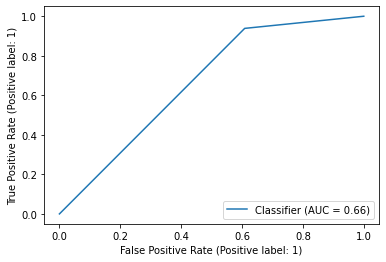

In [56]:
metrics.RocCurveDisplay.from_predictions(y_test, pred)

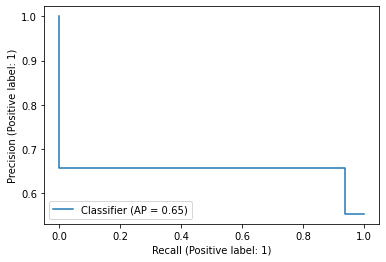

In [57]:
metrics.PrecisionRecallDisplay.from_predictions(y_test, pred)

In [58]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.84      0.39      0.53        92
         1.0       0.66      0.94      0.77       114

    accuracy                           0.69       206
   macro avg       0.75      0.66      0.65       206
weighted avg       0.74      0.69      0.67       206



Предсказания более осмысленные, хотя и "сдвинуты" в сторону частотного класса: у него высокая полнота предсказания. Но класс 0 тоже предсказывается в 39% его экземпляров.

Построим матрицу ошибок:

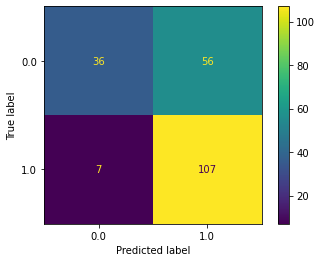

In [59]:
cm = metrics.confusion_matrix(y_test, pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

В статье confusion matrix выглядит так:
<img src="conf_matrix_orig.png" width="300" height="300">
Сравним нашу матрицу о шибок с матрицей ошибок в статье:

Классы 0 и 1 заменены между собой. В остальном цифры практически идентичные.

Выведем базовые метрики по классам исходя из матрицы в статье:

In [60]:
d = {}
d['precision1'] = 37/(37.+8)
d['recall1'] = 37/(37.+59)
d['precision0'] = 110./(110+59)
d['recall0'] = 110./(110+8)
d['F1-1'] = 2 * (d['precision1'] * d['recall1']) / (d['precision1'] + d['recall1'])
d['F1-0'] = 2 * (d['precision0'] * d['recall0']) / (d['precision0'] + d['recall0'])
d = {k:round(val, 2) for (k, val) in d.items()}
d

{'precision1': 0.82,
 'recall1': 0.39,
 'precision0': 0.65,
 'recall0': 0.93,
 'F1-1': 0.52,
 'F1-0': 0.77}

Базовые метрики для классов в статье (P, R, F1) почти совпадают с нашими или чуть ниже наших.

# Выводы

В нашем эксперименте по параметрам тональности результат нулевой или практически нулевой. 

Т.е. у нас получилась модель, которая дает совсем неразумный результат: не обучается никакой закономерности деления на классы. А также модель, которая выучивает какие-то закономерности, но с очень плохим бесполезным результатом.

Результат по тональности не воспроизвелся.

В нашем эксперименте по техническим параметрам + тональности результат по PR-AUC и Roc-AUC 
напрямую не сравним c результатами, показанными в статье. 
Потому что распределение классов немного другое; более того, классы, вероятно, были перепутаны автором статьи (см. выше).

Но можно сделать прямое сравнение по качестве распознавания каждого класса: P, R, F1. 
В нашем эксперименте эти показатели очень близки к представленным в статье. 
Это также видно по очень похожим цифрам в матрице ошибок.

В связи с этим вызывают вопросы такие высокие метрики PR-AUC и Roc-AUC, показанные в статье.

Результат по техническим параметрам + тональности подтвердился.

Возможные причины расхождения результатов:
1. Расхождение в принципе выбора релевантных новостей - мы выбирали по строкам 'busines' и 'financ' в категории. В статье нет не прописан алгоритм выбора. Есть возможность, что наш итоговый набор из-за этого сильно отличается от набора в статье. Это бы также объяснило другое распределение классов.

Тем не менее, мне кажется более вероятным, что наша выборка новостей очень похожа на оригинальную, а распределение между классами в статье перепутано. Слишком близки распределения, если поменять местами 0 и 1:)

2. Сильное расхождение в результатах по тональности; разные классы 0 и 1; сходство базовых метрик в результате по техническим параметрам+тональности при расхождении PR-AUC и ROC-AUC наводят меня на мысль, что в оригинальном исследовании есть какие-то ошибки в рассчете метрик PR-AUC и ROC-AUC, но, вероятно, не в самом эксперименте.